# A/B-тестирование

In [ ]:
import requests
import pandas as pd
from urllib.parse import urlencode
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as stat
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)     

from plotly import graph_objects as go

### Постановка задачи

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

#### Загрузим данные

In [2]:
def download_data(link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = link 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return pd.read_csv(download_url)

In [5]:
final_ab_events = download_data('https://disk.yandex.ru/d/pgKgZ9lRp0Enwg')

In [11]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [7]:
marketing_events = download_data('https://disk.yandex.ru/d/ZVC7GUYYckKnGQ')

In [12]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [81]:
new_users = download_data('https://disk.yandex.ru/d/Qrto8Gerpu424g')

In [82]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [10]:
participants = download_data('https://disk.yandex.ru/d/nhGUR3ZkNIG4VA')

In [14]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


#### датасет final_ab_events

In [15]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [31]:
# пропуски в столбце details означают отсутсвие покупок, заполним нулями:
final_ab_events = final_ab_events.fillna(0)

In [32]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [102]:
# приведем дату к типу datetime:
final_ab_events['event_dt']  = pd.to_datetime(final_ab_events['event_dt'])

In [21]:
# проверим дубликаты
final_ab_events.duplicated().sum()

0

#### marketing_events

In [22]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [24]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

#### new_users

In [108]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [109]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [110]:
new_users.duplicated().sum()

0

In [111]:
new_users.user_id.nunique()

61733

#### participants

In [112]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [113]:
participants.duplicated().sum()

0

### Проверим соответствие данным техническому заданию.

####  
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04
ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%

Мы оцениваем резлутаты на 14 день со дня регистрации, дата остановки теста 2021-01-04, мы не должны рассматривать тех пользователей, которые зарегистрировались позже 2021-01-04 минус 2 недели, те после 16 декабря:


In [114]:
valid_new_users = new_users.query('first_date< "2020-12-17"')

In [115]:
# Проверим время регистрации: 
(valid_new_users.first_date.min(), valid_new_users.first_date.max())


(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-16 00:00:00'))

Регстрация соответсвует тех заданию

#### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [116]:
marketing_events.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


### 'Christmas&New Year Promo'  - пересекается со временем проведения теста, это плохо, может повлиять на результаты

Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

In [117]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [118]:
# Помимо нашего теста - recommender_system_test параллельно проходит еще один, посмотрим пересечения в аудитории

In [119]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [120]:
interface_eu_test  = participants.query('ab_test=="interface_eu_test"')
recommender_system_test = participants.query('ab_test=="recommender_system_test"')

In [121]:
merged = interface_eu_test[['user_id']].merge(recommender_system_test[['user_id']], how='inner')

In [122]:
merged.shape[0]

1602

1602 пользователя попали в оба теста, исключим их из наших данных

In [123]:
to_delete_users = merged.user_id.to_list()

In [124]:
recommender_system_test = recommender_system_test.query('~(user_id in @to_delete_users)')

In [125]:
recommender_system_test.shape[0]

5099

Избавимся от столбца ab_test, после чего проверим нет ли у нас пересечений по группам:

In [126]:
recommender_system_test.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test


In [127]:
recommender_system_test = recommender_system_test.drop(columns='ab_test', axis=1)

In [128]:
test_A = recommender_system_test.query('group == "A"')
test_B = recommender_system_test.query('group == "B"')

In [129]:
merged_groups = test_A[['group']].merge(test_B[['group']])

In [130]:
merged_groups

,group


Пересечений пользователей по группам теста нет.

Проверим, что в recommender_system_test попали только пользователи с правильными датами регистрации, удалим тех, у кого дата регистрации не попала в нужный диапазон 

In [131]:
filter_users = valid_new_users.user_id.to_list()

In [132]:
recommender_system_test = recommender_system_test.query('user_id in @filter_users')

In [133]:
recommender_system_test.shape[0]

3263

Количество пользователей сократилось с 5099 до 3263, это почти вдвое ниже ожидаемых 6000 тыс участников

Проверьте равномерность распределения по тестовым группам и правильность их формирования.

In [134]:
group_A =  recommender_system_test.query('group=="A"')
group_B =  recommender_system_test.query('group=="B"')

In [135]:
(group_A.user_id.nunique(), group_B.user_id.nunique())

(1862, 1401)

Распределение пользователей по группам неравномерно - различие более, чем на 25 процентов - это плохо

Проверим, какой процент новых пользователей из региона EU

In [136]:
merged_users = recommender_system_test.merge(valid_new_users, on ='user_id')

In [137]:
merged_users['region'].value_counts()

EU           3035
N.America     148
APAC           43
CIS            37
Name: region, dtype: int64

In [138]:
# Доля валидных пользователей теста из региона EU ко всем новым пользователям:
merged_users.query('region=="EU"').user_id.nunique() / new_users.user_id.nunique()

0.049163332415401814

Целевая аудитория составляет только 5 процентов (укзанных в ТЗ 15%)


Посмотрим на действия пользователей. Необходимо удалить действия пользователей, которые были совершены после 14 дней от регистрации (мы рассматриваем результаты на 14 день)

In [139]:
# сначала соединим пользователей с их действиями:
merged_with_events = recommender_system_test.merge(final_ab_events, on='user_id').merge(valid_new_users[['user_id','first_date']])

In [140]:
merged_with_events = merged_with_events.rename(columns={"first_date":"registration_date"})

In [141]:
merged_with_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10493 entries, 0 to 10492
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            10493 non-null  object        
 1   group              10493 non-null  object        
 2   event_dt           10493 non-null  datetime64[ns]
 3   event_name         10493 non-null  object        
 4   details            10493 non-null  float64       
 5   registration_date  10493 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 573.8+ KB


In [142]:
merged_with_events['stop_activity_date'] = merged_with_events['registration_date'] + timedelta(days=14)

In [143]:
merged_with_events.head()

,user_id,group,event_dt,event_name,details,registration_date,stop_activity_date
0,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-21
1,D1ABA3E2887B6A73,A,2020-12-25 00:04:56,purchase,4.99,2020-12-07,2020-12-21
2,D1ABA3E2887B6A73,A,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,2020-12-21
3,D1ABA3E2887B6A73,A,2020-12-25 00:04:57,product_cart,0.00,2020-12-07,2020-12-21
4,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,product_page,0.00,2020-12-07,2020-12-21


In [144]:
# отфильтруем события:
merged_with_events = merged_with_events.query('event_dt <= stop_activity_date')

In [145]:
merged_with_events.shape[0]

9843

In [146]:
merged_with_events.head()

,user_id,group,event_dt,event_name,details,registration_date,stop_activity_date
0,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-21
2,D1ABA3E2887B6A73,A,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,2020-12-21
4,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,product_page,0.00,2020-12-07,2020-12-21
6,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,login,0.00,2020-12-07,2020-12-21
8,7473E0943673C09E,A,2020-12-16 10:31:31,product_page,0.00,2020-12-16,2020-12-30


In [147]:
# Удалим ненужные столбцы:
merged_with_events = merged_with_events.drop(columns=['registration_date','stop_activity_date'], axis=1)

In [150]:
# Посмотрим равномерность распределения событий по группам теста:
merged_with_events.groupby('group', as_index=False).agg({'user_id':'count'}).\
    rename(columns={'user_id':'events'})

,group,events
0,A,7127
1,B,2716


Раcпределение событий по группам неравномерное

In [155]:
# Распределение событий на пользователя в группах:

merged_with_events.query('group=="A"').user_id.count() / merged_with_events.query('group=="A"').user_id.nunique()

6.846301633045149

In [156]:

merged_with_events.query('group=="B"').user_id.count() / merged_with_events.query('group=="A"').user_id.nunique()

2.6090297790585977

В группе А в среднем 6 событий на пользователя - в группе B - 2   
Явный дисбаланс

Посмотрим распределение событий в выборках по дням:  

In [157]:
merged_with_events['date'] = merged_with_events['event_dt'].dt.date

In [158]:
dates = merged_with_events.date.unique()

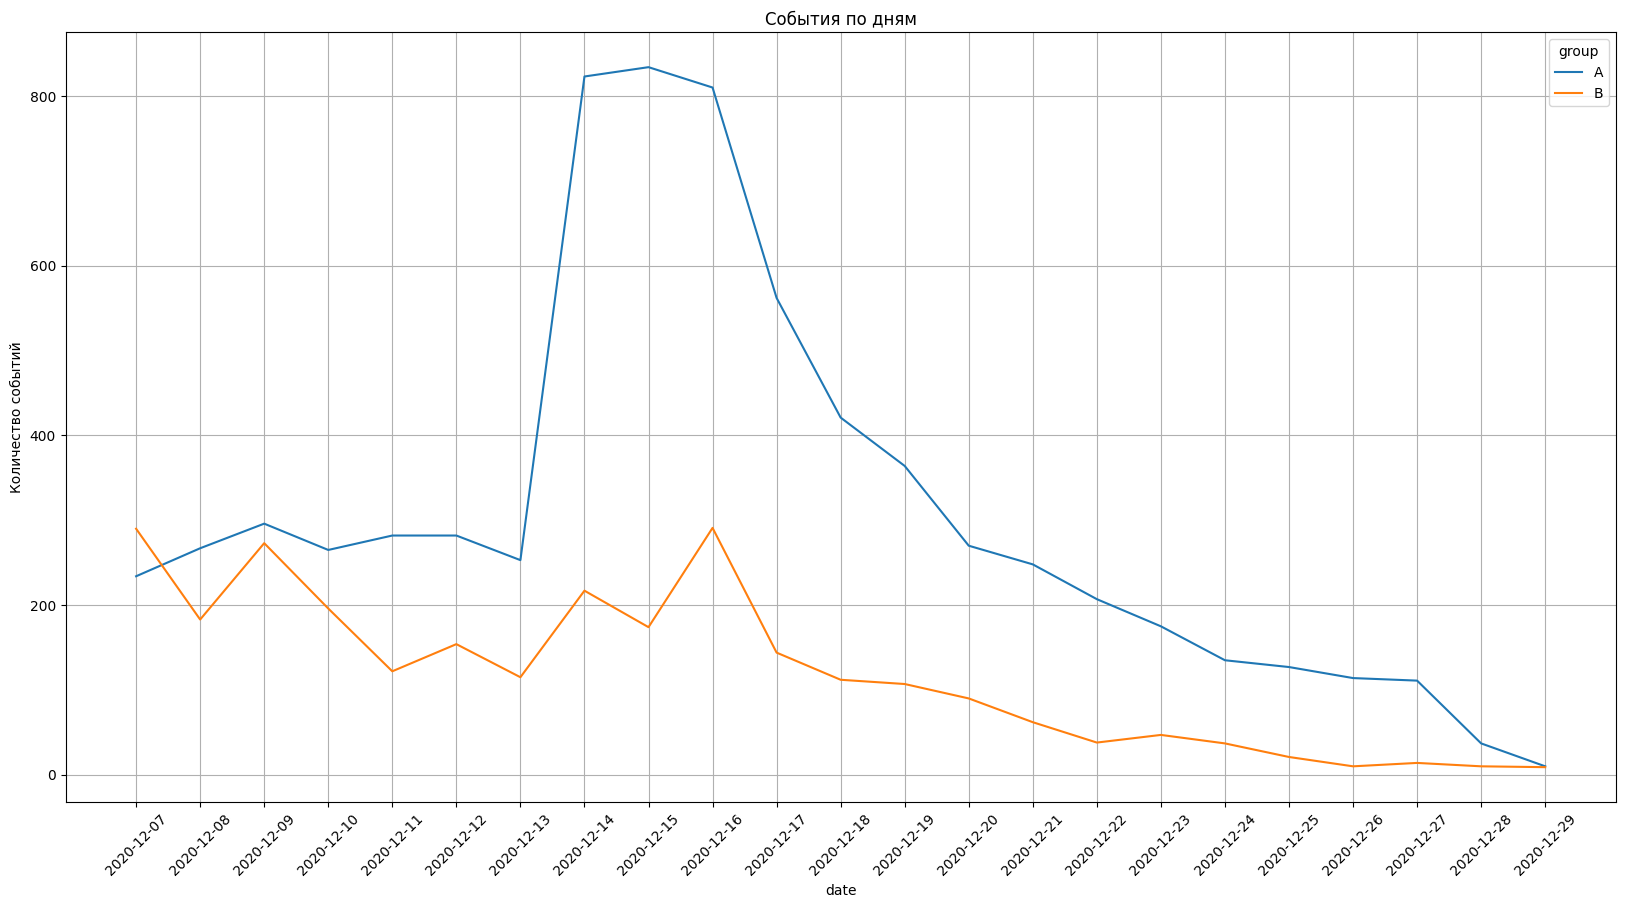

In [162]:
merged_with_events.pivot_table(index='date',
               columns='group',
               values='event_name',
               aggfunc='count',
               fill_value=0).plot(figsize=(20,10), 
                                  grid=True,
                                  xticks=dates,
                                  rot=45)
plt.title(
'События по дням'
)
plt.ylabel('Количество событий')
plt.show()

In [163]:
total_events = merged_with_events.groupby('group', as_index=False).agg({'user_id':'nunique'})

In [165]:
total_events

,group,user_id
0,A,1041
1,B,482


In [166]:
A = merged_with_events.query('group=="A"').groupby('date',as_index=False).agg({'event_dt':'count'})
B = merged_with_events.query('group=="B"').groupby('date',as_index=False).agg({'event_dt':'count'})
A['average_events_user'] = A['event_dt'] / total_events.loc[0,'user_id']
B['average_events_user'] = B['event_dt'] / total_events.loc[1,'user_id']

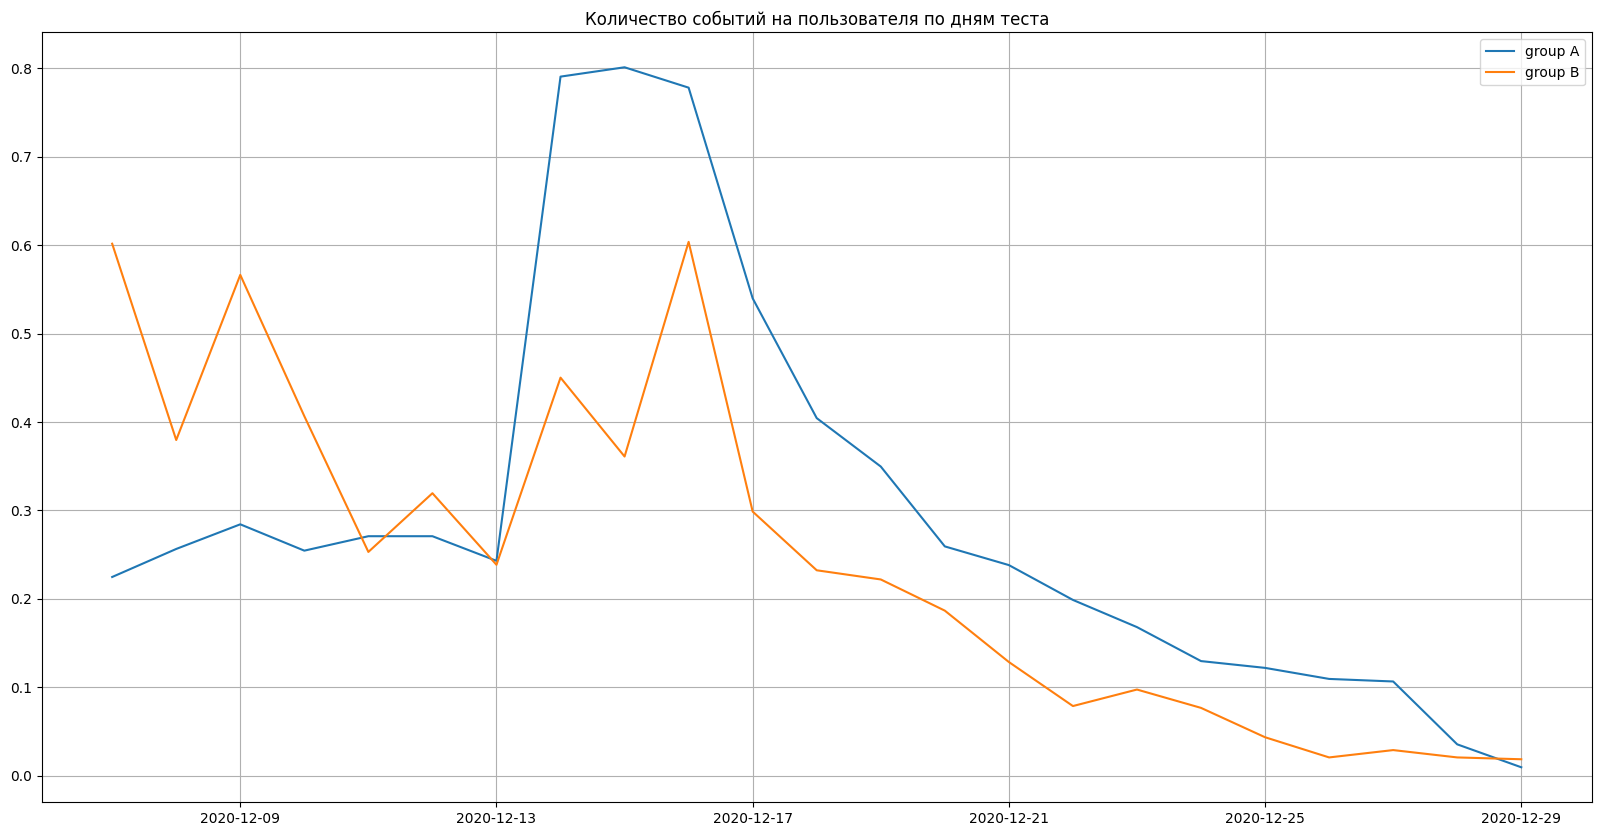

In [180]:
plt.figure(figsize=(20,10))
plt.plot(A['date'], A['average_events_user'], label='group A')
plt.plot(B['date'], B['average_events_user'], label='group B')
plt.title(
'Количество событий на пользователя по дням теста'
)
plt.xticks=dates
plt.grid()
plt.legend()
plt.show()

Получили довольно неоднозначные данные: с 13 по 18 декабря огромный всплеск активности группы А по сравнению с группой B - возможно, имеет место какая-то дополнительная акция, которую не учли в ТЗ?  
По количеству событий на пользователя сначала лидировала группа B, но потом контрольная группа ее опередила и до самого конца теста оставлась в лидерах. В конце теста показатли сравнялись.

In [240]:
# Построим воронку
fig = go.Figure()
fig.add_trace(go.Funnel(
    name= 'group A',
      y = ['login', 'product_page', 'product_cart',  'purchase'],
      x  = merged_with_events.query('group=="A"')\
        .groupby('event_name').user_id.nunique().sort_values(ascending=False),
         textinfo = "value+percent initial"
))
fig.add_trace(go.Funnel(
    name='group B',
    orientation='h',
    y = ['login', 'product_page', 'product_cart',  'purchase'],
    x  = merged_with_events.query('group=="B"')\
        .groupby('event_name').user_id.nunique().sort_values(ascending=False),
        textinfo = "value+percent initial"
))
fig.show()

По воронке видно, что конверсия контрольной группы выше, чем у тестируемой на всех шагах

#### Оцените результаты A/B-тестирования

Тест проведен со множеством нарушений:  
1. Одновременно проводилось 2 теста, пользоватли перемешались, пришлось удалить более 1600 пользователей  
2. Во время проедения теста была маркетиговая кампания, она могла повлиять на результаты теста  
3. Валидных участников теста было почти вдвое меньше, чем планировалось  
4. Количество новых пользователей из EU было меньше планируемого  процента  
5. На графике активности пользователей по дням были необъяснимые всплески активности в одной из групп  

#### Проверьте статистическую разницу долей z-критерием.

In [185]:
# Посмотрим,какая доля пользователей была на каждом этапе воронки по группам и перешла на следующий шаг:
merged_with_events.head()

,user_id,group,event_dt,event_name,details,date
0,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,purchase,99.99,2020-12-07
2,D1ABA3E2887B6A73,A,2020-12-07 14:43:29,product_cart,0.00,2020-12-07
4,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,product_page,0.00,2020-12-07
6,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,login,0.00,2020-12-07
8,7473E0943673C09E,A,2020-12-16 10:31:31,product_page,0.00,2020-12-16


In [226]:
groupA = merged_with_events[['user_id','group','event_name']].\
    query('group == "A"').groupby('event_name')['user_id'].nunique().reset_index()\
        .sort_values(by='user_id', ascending=False)

In [227]:
groupA['%A'] = groupA.user_id.shift() 

In [228]:
groupA['%A'] = round((groupA['user_id']/groupA['%A'])*100)

In [229]:
groupA

,event_name,user_id,%A
0,login,1041,NaN
2,product_page,674,65.0
1,product_cart,315,47.0
3,purchase,310,98.0


In [230]:
groupB = merged_with_events[['user_id','group','event_name']].\
    query('group == "B"').groupby('event_name')['user_id'].nunique().reset_index()\
        .sort_values(by='user_id', ascending=False)

In [231]:
groupB['%B'] = groupB.user_id.shift()

In [232]:
groupB['%B'] = round((groupB['user_id']/groupB['%B'])*100)

In [233]:
groupB

,event_name,user_id,%B
0,login,481,NaN
2,product_page,273,57.0
1,product_cart,133,49.0
3,purchase,129,97.0


In [234]:
merged_groups = groupA.merge(groupB, on='event_name')

In [235]:
merged_groups = merged_groups.rename(columns={'user_id_x':'groupA','user_id_y':'groupB'})

In [236]:
merged_groups['step'] = merged_groups.index

In [237]:
merged_groups

,event_name,groupA,%A,groupB,%B,step
0,login,1041,NaN,481,NaN,0
1,product_page,674,65.0,273,57.0,1
2,product_cart,315,47.0,133,49.0,2
3,purchase,310,98.0,129,97.0,3


Сформулируем гипотезы для проверки гипотезы о равенстве долей:  
H0: доли уникальных пользователей на всех этапах воронки в группах А и B не отичаются  
H1: доли отличаются  
Критерий значимости выберем равным 0.05. Так как мы будем проводить множественные тесты, нобходимо применить поправку критерия значимости. Применим поправку Бонферрони.  

In [238]:
def test(step, i, k):
    
    # поправка Бонферрони для множественных тестов
    alpha = 0.05 / k
    
    successes = merged_groups.loc[i, ['groupA', 'groupB']].values
    trials = merged_groups.loc[0, ['groupA', 'groupB']].values
    print('funnel_step:', merged_groups['event_name'][i])
    
    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 

    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = stat.norm(0, 1) 

    z_value = difference / np.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print()
    print('*-'*50)

In [239]:
for i in range(1,4):
    test(merged_groups, i, 3)

funnel_step: product_page
p-значение:  0.002802362544466863
Отвергаем нулевую гипотезу: между долями есть значимая разница

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
funnel_step: product_cart
p-значение:  0.299180368159186
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
funnel_step: purchase
p-значение:  0.23599361402458197
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


Получили данные, что есть значимая разница в долях просматривающих продуктовую страницу, а дальне по воронке однозначных выводов сделать не получилось  

## Выводы:  
1. В процессе работы над ab тестом обработали даные пользователей за конец  2020 - начало 2021 года.  
2. В соответствии с техническим заданием, были отобраны пользователи, которые с момента регистрации могли 14 дней участвовать в тесте.  
3. Из теста были исключены пользователи, принимавшие участие в параллельном тесте  
4. Тест проводился с нарушениями:  
    - количество пользователей было ниже почти вдвое  (3200 вместо 6000) 
    - процент новых пользователей из EU не был соблюден  (5 процентов вместо 15)
    - был дисбаланс пользователей в группах теста  
    - была замечена аномальная активность в контрольной группе в течение нескольких дней, не объясненная ТЗ
    - во время теста была проведена маркетинговая кампания  
5. Построена воронка перехода уникальных пользователей  между шагами    
5. Проведен z-тест равенства долей уникальных пользователей по шагам воронки.   
Тест показал статистически значимую разницу долей при переходе от первого шага login ко второму - product_page   
Статистически значимой разницы долей на следующих этапах воронки не выявлено.  
В целом, учитывая множественные нарушения проведения теста и неоднозначные статистические выводы, можно заключить, что тест проведен некачественно, его результатам доверять нельзя.